<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Assignment 7

In [3]:
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express

import nltk
nltk.download('stopwords')
nltk.download('punkt')

!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
#setting up Kaggle & TuriCreate package s
import json
import os

!mkdir /root/.kaggle/
# Installing the Kaggle package

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"liaddekel","key":"bf0297555b2915c6c31a8f6579de9483"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


**Question 1:** Select two books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape or Gephi (20pt).


In [5]:
!mkdir ./datasets
!mkdir ./datasets/lor

# download the dataset from Kaggle and unzip it
!kaggle datasets download ashishsinhaiitr/lord-of-the-rings-text -p ./datasets/lor
!unzip ./datasets/lor/*.zip  -d ./datasets/lor/

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/lor’: File exists
lord-of-the-rings-text.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/lor/lord-of-the-rings-text.zip
replace ./datasets/lor/01 - The Fellowship Of The Ring.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ./datasets/lor/01 - The Fellowship Of The Ring.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./datasets/lor/01 - The Fellowship Of The Ring.txt  
  inflating: ./datasets/lor/02 - The Two Towers.txt  
  inflating: ./datasets/lor/03 - The Return Of The King.txt  


In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')

lor2 = './datasets/lor/02 - The Two Towers.txt'
lor3 = './datasets/lor/03 - The Return Of The King.txt'

def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

def get_txt_entities(txt, times_dict):
    txt = txt.replace("\n", " ")
    doc = nlp(txt)
    d = get_entites_dict_from_text(txt) 
    entities_dict = {}

    for k in d.keys():
        min_times = times_dict.get(k)
        if not min_times:
            min_times = times_dict['DEFAULT']

        entity_dict = {k:v for k,v in d[k].items() if v>min_times}
        entities_dict[k] = entity_dict
    return entities_dict


In [7]:
from tqdm import tqdm
from itertools import product

TIMES_DICT = {
    'PERSON':1,
    'LOC':1,
    'DEFAULT':1
}

def get_txt_links(txt):
    links_set = set()
    txt_ents = get_txt_entities(txt, TIMES_DICT)
    # a link is added for each couple (LOCATION, PERSON) in the same
    # paragraph.
    persons = txt_ents.get('PERSON')
    locations = txt_ents.get('LOC')
    if persons and locations:
        for link in product(persons, locations):
            links_set.add(link)
    return links_set

def get_persons_links(book_path):
    txt = open(book_path,"r", encoding="utf8", errors="ignore").read()
    links_set = set()
    paragraphs_list = txt.split("\n\n")
    para = paragraphs_list[0]
    for para in tqdm(paragraphs_list):
        for link in get_txt_links(para):
            links_set.add(link)
    return links_set
    
l2 = get_persons_links(lor2)
l3 = get_persons_links(lor3)

100%|██████████| 193/193 [00:44<00:00,  4.33it/s]


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))

g2 = nx.Graph()
g2.add_edges_from(l2)
nx.write_gml(g2, "./datasets/lor2.gml")

g3 = nx.Graph()
g3.add_edges_from(l3)
nx.write_gml(g3, "./datasets/lor3.gml")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 720x720 with 0 Axes>

As we can see below, in **lord of the rings 2** - the most common locations were the **river**, the **north**, while the **misty mountains** on the left were much less.

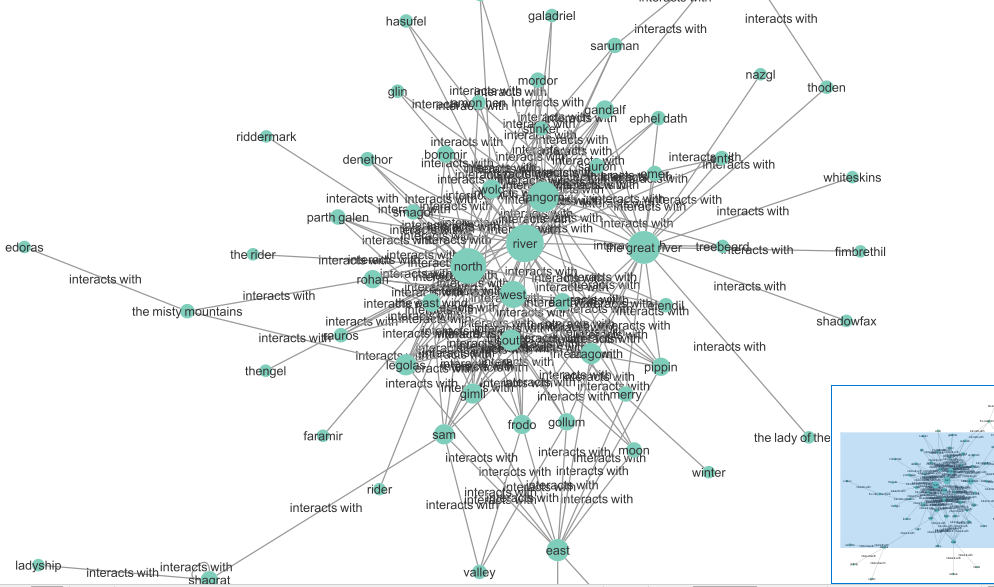

As we can see below, in **lord of the rings 3** - the most 
common locations were the **shire**, the **east** and the **valley** while the **bush** on the 
bottom was much less.

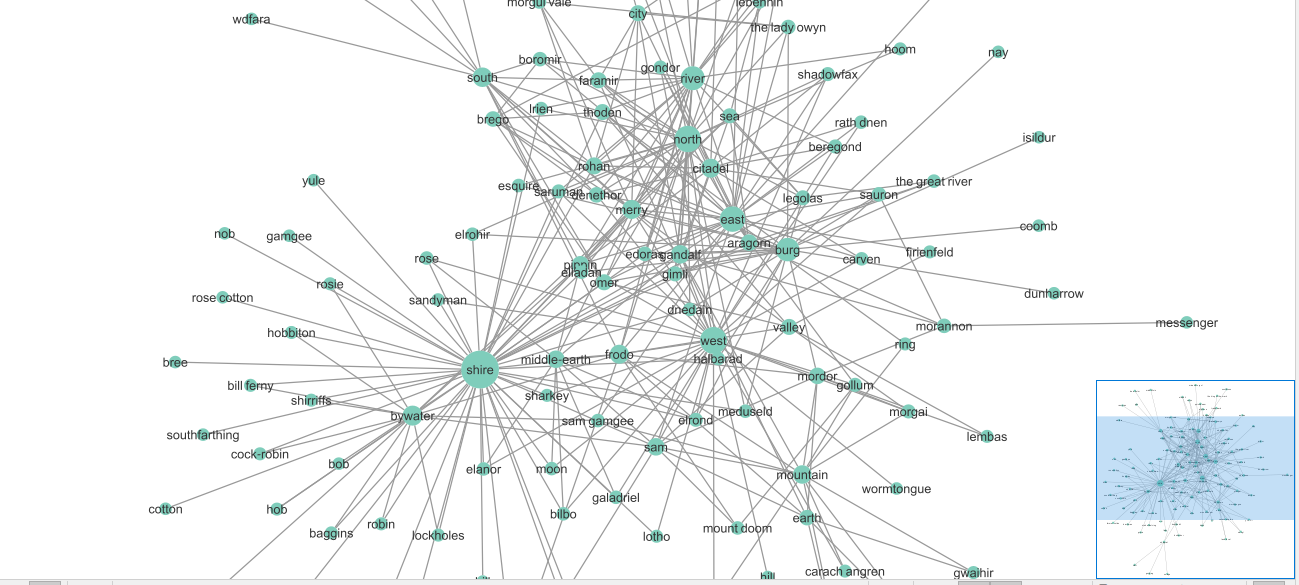

**Question 2:** Use the [Friends TV Show Transcript](https://www.kaggle.com/ryanstonebraker/friends-transcript)
to create and evaluate a classifier that given a line of text can predict
 who is the "friend" that said it (20pt). Using sentiment analysis identify who are the most and less friendly friends (20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

In [9]:
!mkdir ./datasets
!mkdir ./datasets/friends

# download the dataset from Kaggle and unzip it
!kaggle datasets download ryanstonebraker/friends-transcript -p ./datasets/friends
!unzip ./datasets/friends/*.zip  -d ./datasets/friends/

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/friends’: File exists
friends-transcript.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/friends/friends-transcript.zip
replace ./datasets/friends/friends_quotes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./datasets/friends/friends_quotes.csv  


In [10]:
import turicreate as tc
%matplotlib inline

sf = tc.SFrame.read_csv('./datasets/friends/friends_quotes.csv')
sf

Finished parsing file /content/datasets/friends/friends_quotes.csv

Parsing completed. Parsed 100 lines in 0.249351 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,str,str,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/friends/friends_quotes.csv

Parsing completed. Parsed 60291 lines in 0.15225 secs.

author,episode_number,episode_title,quote,quote_order,season
Monica,1.0,Monica Gets A Roommate,There's nothing to tell!He's just some guy I ...,0.0,1.0
Joey,1.0,Monica Gets A Roommate,"C'mon, you're going outwith the guy! There's ...",1.0,1.0
Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice.So does he have a hum ...",2.0,1.0
Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don'twant her to go through ...",4.0,1.0
Monica,1.0,Monica Gets A Roommate,"Okay, everybody relax.This is not even a date. ...",5.0,1.0
Chandler,1.0,Monica Gets A Roommate,Sounds like a date to me.,6.0,1.0
Chandler,1.0,Monica Gets A Roommate,"Alright, so I'm back inhigh school, I'm stan ...",7.0,1.0
All,1.0,Monica Gets A Roommate,"Oh, yeah. Had that dream.",8.0,1.0
Chandler,1.0,Monica Gets A Roommate,"Then I look down, and Irealize there's a ...",9.0,1.0


In [11]:
sf['author']

dtype: str
Rows: 60291
['Monica', 'Joey', 'Chandler', 'Phoebe', 'Phoebe', 'Monica', 'Chandler', 'Chandler', 'All', 'Chandler', 'Joey', 'Chandler', 'Joey', 'Phoebe', 'Chandler', 'Monica', 'Chandler', 'Ross', 'Joey', 'Monica', 'Ross', 'Chandler', 'Monica', 'Joey', 'Monica', 'Ross', 'Phoebe', 'Ross', 'Phoebe', 'Ross', 'Monica', 'Ross', 'Joey', 'Ross', 'Chandler', 'Ross', 'Monica', 'Ross', 'Joey', 'Joey', 'Ross', 'Chandler', 'Monica', 'Rachel', 'Waitress', 'Monica', 'Rachel', 'Ross', 'Monica', 'Rachel', 'Monica', 'Rachel', 'Monica', 'Chandler', 'Ross', 'Rachel', 'Phoebe', 'Chandler', 'Joey', 'Phoebe, Ross, Chandler, and Joey', 'Rachel', 'Ross', 'Rachel', 'Monica', 'Rachel', 'Monica', 'Phoebe', 'Rachel', 'Phoebe', 'Monica', 'Joey', 'Monica', 'Joey', 'Chandler', 'Paul', 'Monica', 'Joey', 'Ross', 'Monica', 'Ross', 'Monica', 'Chandler', 'Monica', 'Rachel', 'Monica', 'Ross', 'Monica', 'Ross', 'Phoebe', 'Monica', 'All', 'Chandler', 'Monica', 'Ross', 'Monica', 'Phoebe', 'Joey', 'Paul', 'Joey', 'M

In [0]:
# since there are more then 3000 authors we will stay
# with the quotes of the main actors
main_actors = ["Monica", "Joey", "Phoebe", "Chandler", "Rachel", "Ross"]
sf = sf.filter_by(main_actors, 'author')


# calculate word count
sf['word_count'] = tc.text_analytics.count_words(sf['quote'])
# calculate 1-ngrams and 2-ngrams
sf['words_1grams'] = tc.text_analytics.count_ngrams(sf['quote'], n=1, method='word')
sf['words_2grams'] = tc.text_analytics.count_ngrams(sf['quote'], n=2, method='word')

In [27]:
train, test = sf.random_split(0.8)
cls = tc.classifier.create(train,features=['word_count', 'words_1grams', 'words_2grams'], target="author")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 34546

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 144922

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.350545     | 0.244920          | 0.231446            | 1.768806          | 1.777009            |

| 2         | 2.672177     | 0.253199          | 0.218252            | 1.752402          | 1.767232            |

| 3         | 4.018146     | 0.265848          | 0.229247            | 1.739434          | 1.760016            |

| 4         | 5.308878     | 0.273433          | 0.235294            | 1.729201          | 1.754755            |

| 5         | 6.646778     | 0.277630          | 0.242991            | 1.719563          | 1.749870            |

| 10        | 13.098094    | 0.312337          | 0.272677            | 1.683472          | 1.730566            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 34546

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 144922

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.119576     | 0.246309          | 0.220451            | 1.735727          | 1.762218            |

| 2         | 2.223843     | 0.253749          | 0.224849            | 1.732741          | 1.757780            |

| 3         | 3.317385     | 0.255225          | 0.230346            | 1.731642          | 1.756532            |

| 4         | 4.420641     | 0.261564          | 0.239142            | 1.730936          | 1.755473            |

| 5         | 5.528762     | 0.261275          | 0.239692            | 1.730817          | 1.754101            |

| 10        | 11.027293    | 0.259306          | 0.236394            | 1.729873          | 1.754092            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 34546

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 144922

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.320060     | 0.244920          | 0.231446            | 1.733052          | 1.757694            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 34546

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 144922

Number of coefficients      : 724615

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.637835     | 0.723846          | 0.274876            |

| 1         | 4        | 1.000000  | 33.263918    | 0.814769          | 0.288070            |

| 2         | 5        | 1.000000  | 65.904128    | 0.844324          | 0.281473            |

| 3         | 6        | 1.000000  | 98.902104    | 0.864413          | 0.262232            |

| 4         | 7        | 1.000000  | 132.673731   | 0.875210          | 0.262782            |

| 6         | 9        | 1.000000  | 200.049212   | 0.888612          | 0.255635            |

| 7         | 10       | 1.000000  | 234.557399   | 0.891767          | 0.251237            |

| 8         | 11       | 1.000000  | 268.583249   | 0.893620          | 0.247389            |

| 9         | 12       | 1.000000  | 301.898811   | 0.895820          | 0.244090            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.2726772952171523
PROGRESS: RandomForestClassifier          : 0.23639362286970864
PROGRESS: DecisionTreeClassifier          : 0.2314458493677845
PROGRESS: LogisticClassifier              : 0.2440901594282573
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [28]:
cls.evaluate(test)

{'accuracy': 0.2614035087719298,
 'auc': 0.6167404747456783,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 36
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |    Rachel    |      Rachel     |  573  |
 |    Monica    |       Ross      |  578  |
 |   Chandler   |       Joey      |  145  |
 |     Ross     |       Joey      |  191  |
 |    Rachel    |      Monica     |  249  |
 |    Monica    |      Phoebe     |   42  |
 |    Monica    |     Chandler    |  171  |
 |    Monica    |      Monica     |  341  |
 |     Ross     |      Rachel     |  237  |
 |     Joey     |      Rachel     |  209  |
 +--------------+-----------------+-------+
 [36 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.24808799355252195,
 'log_loss': 1.7290001905550203

In [14]:
from afinn import Afinn
from turicreate import aggregate as agg
afinn = Afinn()

sf['afinn_score'] = sf['quote'].apply(lambda t: afinn.score(t))
sf_affin_avg = sf.groupby(key_column_names='author',operations={'avg_affin': agg.AVG('afinn_score')})
# higher affin score means more positive
# hence we can see that the most positive is rachel and chandler is less :)
sf_affin_avg.sort('avg_affin', ascending = False)

author,avg_affin
Rachel,0.5578264005770612
Phoebe,0.5362686567164178
Joey,0.5325467860048821
Ross,0.4883174681666461
Monica,0.4615486961149548
Chandler,0.4354967948717949


In [19]:
sf['season'] = sf['season'].astype(int)

# concatenate the quotes of each episode in each season
sf_episodes = sf.groupby(key_column_names=['episode_number','season'], operations={'ep_quotes': agg.CONCAT('quote')})
# calculate word count
sf_episodes['word_count'] = tc.text_analytics.count_words(sf_episodes['ep_quotes'])
# calculate 1-ngrams and 2-ngrams
sf_episodes['words_1grams'] = tc.text_analytics.count_ngrams(sf_episodes['ep_quotes'], n=1, method='word')
sf_episodes['words_2grams'] = tc.text_analytics.count_ngrams(sf_episodes['ep_quotes'], n=2, method='word')
sf_episodes

episode_number,season,ep_quotes,word_count,words_1grams
10.0,9,"[Really?, You kidding?You're the most beaut ...","{'person': 1.0, 'ass':1.0, 'kick': 1.0, ...","{'aside': 1, 'adultery':1, 'nice': 1, 'kick': 1, ..."
12.0,9,"[Hey, Hey. So where'sMon?, Oh, she's at home, ...","{'discipline': 1.0,'hell': 1.0, 'feed': ...","{'discipline': 1, 'door':1, 'head': 1, 'both': 1, ..."
11.0,7,"[Hi!, Another cheesecakecame! They delivered it ...","{'leaving': 1.0, 'which':1.0, 'havin\x92': 1.0, ...","{'monica\x92s': 1,'which': 1, 'sits': 1, ..."
20.0,7,"[Yeah., (entering) Hey!,Hey!, Hey!, So Joey I ...","{'keeton': 1.0,'matters': 1.0, ...","{'matters': 1, 'matter':1, 'time\x92s': 1, ..."
6.0,7,"[Okay, the reason why Iasked you guys out to ...","{'exits': 1.0, 'excuse':1.0, 'quietly': 1.0, ...","{'exits': 1, 'excuse': 1,'slowly': 1, 'hell': 1, ..."
21.0,5,"[I'm fine, thanks., (ToMonica) Yeah, see, I ...","{'sold': 1.0,'defrosting': 1.0, ...","{'bowls': 1, 'pizza': 1,'anymore': 1, 'gut': 1, ..."
22.0,6,"[No., A little bit.,Okay., Ohh, okay., (from ...","{'forgot': 1.0, 'meant':1.0, 'realizes': 1.0, ...","{'meant': 1, 'shaking':1, 'sees': 1, 'ehh': 1, ..."
14.0,3,"[Oh. (puts her hand overhis mouth), (singing) ...","{'arm': 1.0, 'glad': 1.0,'rubs': 1.0, 'saddest': ...","{'rubs': 1, 'smiles': 1,'icky': 1, 'stepped': 1, ..."
4.0,5,[(In a sexy voice) Comein. I've been waiting ...,"{'knowing': 1.0, 'hugs':1.0, 'sweetie': 1.0, ...","{'gives': 2, 'listens':2, 'crazy': 1, 'drivi ..."
20.0,4,[Are you kidding me?!Joey. Joey! Joey! Joey! ...,"{'shrugs': 1.0, 'oughta':1.0, 'comes': 1.0, ...","{'shrugs': 1, 'comes': 1,'wait': 1, 'knocked': 1, ..."


In [20]:
train, test = sf_episodes.random_split(0.8)
cls = tc.classifier.create(train,features=['word_count', 'words_1grams', 'words_2grams'], target="season")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 151

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 141721

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.774180     | 1.000000          | 0.250000            | 1.459928          | 2.099854            |

| 2         | 1.588390     | 1.000000          | 0.375000            | 1.014952          | 1.964381            |

| 3         | 2.423792     | 1.000000          | 0.250000            | 0.738251          | 1.845270            |

| 4         | 3.233413     | 1.000000          | 0.375000            | 0.552404          | 1.784421            |

| 5         | 4.019278     | 1.000000          | 0.375000            | 0.421450          | 1.757715            |

| 10        | 7.869252     | 1.000000          | 0.375000            | 0.131223          | 1.582538            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 151

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 141721

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.593665     | 0.894040          | 0.375000            | 0.598149          | 1.861890            |

| 2         | 1.176908     | 0.947020          | 0.250000            | 0.499131          | 2.024034            |

| 3         | 1.807170     | 0.986755          | 0.500000            | 0.453465          | 1.741150            |

| 4         | 2.360472     | 0.993378          | 0.500000            | 0.473808          | 1.856603            |

| 5         | 2.947847     | 1.000000          | 0.500000            | 0.450920          | 1.658173            |

| 10        | 5.821361     | 1.000000          | 0.500000            | 0.456573          | 1.616275            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 151

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 141721

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.764589     | 1.000000          | 0.250000            | 0.336772          | 1.842949            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 151

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 141721

Number of coefficients      : 1275498

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 0.664469     | 0.986755          | 0.250000            |

| 1         | 5        | 0.500000  | 1.222814     | 1.000000          | 0.250000            |

| 2         | 6        | 0.625000  | 1.630490     | 1.000000          | 0.250000            |

| 3         | 8        | 0.625000  | 2.188029     | 1.000000          | 0.250000            |

| 4         | 10       | 0.625000  | 2.760915     | 1.000000          | 0.250000            |

| 8         | 17       | 0.625000  | 4.832120     | 1.000000          | 0.250000            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.375
PROGRESS: RandomForestClassifier          : 0.5
PROGRESS: DecisionTreeClassifier          : 0.25
PROGRESS: LogisticClassifier              : 0.25
PROGRESS: ---------------------------------------------
PROGRESS: Selecting RandomForestClassifier based on validation set performance.


In [21]:
cls.evaluate(test)

{'accuracy': 0.5777777777777777, 'auc': nan, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 23
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      8       |        8        |   2   |
 |      6       |        6        |   3   |
 |      9       |        9        |   1   |
 |      4       |        7        |   2   |
 |      7       |        7        |   3   |
 |      3       |        3        |   3   |
 |      8       |        6        |   2   |
 |      10      |        10       |   6   |
 |      1       |        1        |   4   |
 |      5       |        6        |   1   |
 +--------------+-----------------+-------+
 [23 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'f1_score': 0.5698486698486698, 'log_loss': 1.4418651775111186, 'precision': 0.639